In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

import ray
import time
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import torch
from torch import nn
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [2]:
def define_pandas_options():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
def string_to_vector(s):
    try:
        s = s.split('[')[1].split(']')[0]
        x = float(s.split()[0])
        y = float(s.split()[1])
        return np.array([x, y])
    except AttributeError:
        return None

def get_position_delta(row):
    return row.s / 10 * row.dir_vec

def get_relative_position(row):
    if row.frameId == 1:
        return np.array([0, 0])
    else:
        last_pos = row.shift(1).rel_pos
        return last_pos + row.pos_delta

# Prep data

In [4]:
prog_start = time.time()

In [6]:
pl_cols = ['gameId', 'playId', 'offense_h_play', 'offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived', 'offense_h_to_end', 'defense_h_play', 'defense_h_presnap', 'defense_h_to_throw', 'defense_h_to_arrived', 'defense_h_to_end', 'offense_p_play', 'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived', 'offense_p_to_end', 'offense_m_play', 'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived', 'offense_m_to_end', 'offense_v_play', 'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived', 'offense_v_to_end', 'offense_a_play', 'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived','offense_a_to_end', 'defense_p_play', 'defense_p_presnap','defense_p_to_throw', 'defense_p_to_arrived', 'defense_p_to_end','defense_m_play', 'defense_m_presnap', 'defense_m_to_throw','defense_m_to_arrived', 'defense_m_to_end', 'defense_v_play', 'defense_v_presnap', 'defense_v_to_throw', 'defense_v_to_arrived','defense_v_to_end', 'defense_a_play', 'defense_a_presnap','defense_a_to_throw', 'defense_a_to_arrived', 'defense_a_to_end','HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']

play_df = pd.read_csv('d20_intermediate_files/play_results.csv', usecols=pl_cols)
play_df['num_routes'] = play_df[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']].T.sum()
play_df.drop(play_df[play_df['num_routes'] == 0].index, inplace=True)
play_df.dropna(inplace=True)

fr_cols = ['gameId', 'playId', 'frameId', 'offense_p_group', 'defense_p_group', 'offense_m_group', 'defense_m_group', 'o_state', 'd_state', 'offense_v_group', 'defense_v_group', 'offense_a_group', 'defense_a_group', 'a_group_ratio']
frame_df = pd.read_csv('d20_intermediate_files/frame_results.csv', usecols=fr_cols)

tr_cols = ['time', 's', 'a', 'dis', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'route', 'pos', 'teamType', 'o_vec', 'dir_vec', 'r_vec']
tracking_df = pd.read_csv('d20_intermediate_files/tracking_results.csv', usecols=tr_cols)

In [7]:
route_types = ['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']
runners = tracking_df.loc[(tracking_df['position'].isin(['QB', 'WR', 'RB', 'TE']))].copy()
del tracking_df

In [8]:
runners['pos'] = runners['pos'].apply(string_to_vector)
runners['o_vec'] = runners['o_vec'].apply(string_to_vector)
runners['dir_vec'] = runners['dir_vec'].apply(string_to_vector)
runners['r_vec'] = runners['r_vec'].apply(string_to_vector)
runners['gpid'] = runners.apply(lambda x: str(x.gameId) + '-' + str(x.playId), axis=1)

In [9]:
qb_positions = runners.loc[(runners['frameId'] == 1) & (runners['position'] == 'QB')][['gpid', 'pos']].copy()

In [10]:
indexNames = runners[runners['route'] == 'undefined'].index
indexNames
# Delete these row indexes from dataFrame
runners.drop(indexNames , inplace=True)

In [11]:
runners = runners.loc[(~runners['route'].isna())]

In [12]:
# Convert nan forced floats to ints and NA
runners['nflId'] = runners['nflId'].astype('Int64')
runners['jerseyNumber'] = runners['jerseyNumber'].astype('Int64')

In [13]:
gpids = runners['gpid'].unique().tolist()

In [14]:
@ray.remote
def process_data(dataset, qb_positions):
    routes_df = pd.DataFrame(columns=['gpid', 'nflId', 'route', 'pos'])
    index = 0
    end_events = ['pass_arrived', 'pass_outcome_caught', 'out_of_bounds',
                       'pass_outcome_incomplete', 'first_contact', 'tackle', 'man_in_motion', 'play_action', 'handoff',
                       'pass_tipped', 'pass_outcome_interception', 'pass_shovel', 'line_set', 'pass_outcome_touchdown',
                       'fumble', 'fumble_offense_recovered', 'fumble_defense_recovered', 'touchdown', 'shift',
                       'touchback', 'penalty_flag', 'penalty_accepted', 'field_goal_blocked']

    gpids = dataset['gpid'].unique().tolist()
    for gpid in gpids:
        try:
            df = dataset.loc[dataset['gpid'] == gpid]
            players = df['nflId'].unique().tolist()
            centre_pos = qb_positions.loc[(qb_positions['gpid'] == gpid)]['pos'].values[0][1]
            for player in players:
                player_df = df.loc[(df['nflId'] == player)]
                if player > 0:
                    start_frame = player_df.loc[player_df['event'] == 'ball_snap']['frameId'].min()
                    end_frame = player_df.loc[player_df['event'].isin(end_events)]['frameId'].min()
                    if end_frame > start_frame:
                        positions = []
                        start_pos = player_df.loc[(player_df['frameId'] == start_frame)]['pos'].values[0]
                        flip_arr = True if start_pos[1] < centre_pos else False
                        for frame in range(start_frame + 1, end_frame + 1):
                            # positions.append(player_df.loc[(player_df['frameId'] == frame)]['pos'].values[0].tolist())
                            new_pos = player_df.loc[(player_df['frameId'] == frame)]['pos'].values[0].tolist()
                            if flip_arr: new_pos[1] = new_pos[1] * -1
                            new_pos.append(player_df.loc[(player_df['frameId'] == frame)]['s'].values[0])
                            positions.append(new_pos)
                        positions = np.array(positions)
                        routes_df.loc[index] = {
                            'gpid': str(gpid),
                            'nflId': int(player),
                            'route': str(player_df.loc[(player_df['frameId'] == 1)]['route'].values[0]),
                            'pos': positions - positions[0]
                        }
                        index += 1
        except IndexError:
            print(f'Data error for gpid {gpid}, player {player} (Start {start_frame} | End {end_frame})')
    return routes_df

In [15]:
n_procs = 24
ray.shutdown()
ray.init(num_cpus=n_procs)

RayContext(dashboard_url='', python_version='3.9.12', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '192.168.1.95', 'raylet_ip_address': '192.168.1.95', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-06-02_19-01-01_749784_14781/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-06-02_19-01-01_749784_14781/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-06-02_19-01-01_749784_14781', 'metrics_export_port': 54196, 'gcs_address': '192.168.1.95:56089', 'address': '192.168.1.95:56089', 'node_id': '89dacebc57fa20bf5e7a99e730e595947a66fa9363061b021404b89d'})

In [16]:
n_gpids = len(gpids)
max_gpids = int(len(gpids[:n_gpids]))
gpid_sets = []
set_pos = 0
step = int(max_gpids / (n_procs - 1))

while set_pos < max_gpids:
    start = 0 if set_pos == 0 else set_pos + 1
    set_pos = set_pos + step
    end = set_pos if set_pos < max_gpids else max_gpids
    gpid_sets.append((start, end))

In [17]:
# Generate vectors of positions
start = time.time()

routes_df = pd.DataFrame(columns=['gpid', 'nflId', 'route', 'pos'])
futures = [process_data.remote(runners.loc[(runners['gpid'].isin(gpids[idx[0]:idx[1]]))], qb_positions) for idx in gpid_sets]
results = ray.get(futures)

for i in range(0, len(results)):
    routes_df = pd.concat([routes_df, results[i]], ignore_index=True)

finish = time.time()
print(f'Took {finish - start} seconds')
routes_df.head()

(process_data pid=15151) Data error for gpid 2018100702-4007, player 2556190 (Start 11 | End 44)
(process_data pid=15152) Data error for gpid 2018112508-1729, player 2561272 (Start 11 | End 44)
(process_data pid=15150) Data error for gpid 2018121000-1364, player 2557991 (Start 11 | End 42)
Took 200.7621169090271 seconds


,gpid,nflId,route,pos
0,2018090600-75,2495454,HITCH,"[[0.0, 0.0, 0.0], [0.030000000000001137, 0.0, ..."
1,2018090600-75,2533040,HITCH,"[[0.0, 0.0, 0.0], [0.010000000000001563, 0.0, ..."
2,2018090600-75,2555415,OUT,"[[0.0, 0.0, 0.0], [0.010000000000001563, 0.009..."
3,2018090600-146,2543583,FLAT,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.04], [0.0099999..."
4,2018090600-146,2552418,CROSS,"[[0.0, 0.0, 0.0], [0.01999999999999602, 0.0199..."


In [18]:
# Convert position sequences to 2d array with np.histogram2d

In [19]:
# Convert 2d array to 1d array

In [20]:
@ray.remote
def find_min_max_from_dataframe(df):
    x = [0, 0]
    y = [0, 0]

    for idx, row in df.iterrows():
        if row['pos'][:, 0].min() < x[0]: x[0] = row['pos'][:, 0].min()
        if row['pos'][:, 0].max() > x[1]: x[1] = row['pos'][:, 0].max()
        if row['pos'][:, 1].min() < y[0]: y[0] = row['pos'][:, 1].min()
        if row['pos'][:, 1].max() > y[1]: y[1] = row['pos'][:, 1].max()

    x = [np.floor(x[0]), np.ceil(x[1])]
    y[0] = -1 * np.ceil(max(abs(y[0]), abs(y[1])))
    y[1] = abs(y[0])

    return x, y

In [21]:
def find_min_max_from_arrays(x_list, y_list):
    x = [0, 0]
    x[0] = x_list[:, 0].min()
    x[1] = x_list[:, 1].max()

    y = [0, 0]
    y[1] = np.abs(y_list.max())
    y[0] = -y[1]

    return x, y

In [22]:
n_rows = len(routes_df)
max_rows = int(len(routes_df[:n_rows]))
row_sets = []
set_pos = 0
step = int(max_rows / (n_procs - 1))

while set_pos < max_rows:
    start = 0 if set_pos == 0 else set_pos + 1
    set_pos = set_pos + step
    end = set_pos if set_pos < max_rows else max_rows
    row_sets.append((start, end))

print(row_sets)

[(0, 2841), (2842, 5682), (5683, 8523), (8524, 11364), (11365, 14205), (14206, 17046), (17047, 19887), (19888, 22728), (22729, 25569), (25570, 28410), (28411, 31251), (31252, 34092), (34093, 36933), (36934, 39774), (39775, 42615), (42616, 45456), (45457, 48297), (48298, 51138), (51139, 53979), (53980, 56820), (56821, 59661), (59662, 62502), (62503, 65343), (65344, 65364)]


In [23]:
start = time.time()

x = []
y = []

futures = [find_min_max_from_dataframe.remote(routes_df[idx[0]:idx[1]]) for idx in row_sets]
results = ray.get(futures)

for i in range(0, len(results)):
    x.append(results[i][0])
    y.append(results[i][1])

x, y = find_min_max_from_arrays(np.array(x), np.array(y))

finish = time.time()
print(f'Took {finish - start} seconds')
print(x, y)

Took 0.5525915622711182 seconds
[-34.0, 68.0] [-45.0, 45.0]


In [24]:
x_dim = int(abs(x[0]) + abs(x[1]))
y_dim = int(abs(y[0]) + abs(y[1]))

In [25]:
grid = np.zeros(x_dim * y_dim).reshape(x_dim, y_dim)

In [26]:
grids = []
for idx, row in routes_df.iterrows():
    grid = np.zeros(x_dim * y_dim).reshape(x_dim, y_dim)
    for position in row['pos']:
        grid[int(position[0]), int(position[1])] = position[2]
    grids.append(grid.reshape(x_dim * y_dim))

In [27]:
routes_df['grid'] = grids
#routes_df.drop(['pos'], axis=1, inplace=True)

In [28]:
prog_end = time.time()
print(f'Program took {prog_end - prog_start} seconds')

Program took 367.1189184188843 seconds


## SVM

In [29]:
# flatten the images
n_samples = len(grids)

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.005, kernel='rbf', max_iter=1000)

# Split data into 60% train and 40% test subsets
x_train, x_test, y_train, y_test = train_test_split(routes_df['grid'].tolist(), routes_df['route'], test_size=0.4, shuffle=False, random_state=1)

scaler = StandardScaler()

scaler.fit(x_train)
x_train2 = scaler.transform(x_train)
x_test2 = scaler.transform(x_test)

# Learn the digits on the train subset
clf.fit(x_train2, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(x_test2)

/home/spencer/Projects/cosc301/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [30]:
print(
    f'Classification report for classifier {clf}:\n'
    f'{metrics.classification_report(y_test, predicted)}\n'
)

Classification report for classifier SVC(gamma=0.005, max_iter=1000):
              precision    recall  f1-score   support

       ANGLE       0.58      0.43      0.50       898
      CORNER       0.46      0.26      0.33      1009
       CROSS       0.40      0.74      0.51      2425
        FLAT       0.63      0.79      0.70      3700
          GO       0.45      0.51      0.48      4874
       HITCH       0.56      0.20      0.30      4247
          IN       0.49      0.37      0.42      1878
         OUT       0.41      0.42      0.41      2772
        POST       0.55      0.26      0.35      1686
      SCREEN       0.41      0.54      0.47      1012
       SLANT       0.39      0.59      0.47      1514
       WHEEL       0.00      0.00      0.00       131

    accuracy                           0.48     26146
   macro avg       0.44      0.43      0.41     26146
weighted avg       0.49      0.48      0.46     26146




Confusion Matrix:
[[ 389    1   30  130   37   67   29   91    3   51   70    0]
 [   6  261  222   40  319   17    7   83    1   17   36    0]
 [   6    0 1787  197   93   30   10   12   27   96  167    0]
 [  29    0  342 2940   30   13    0   44    0  272   29    1]
 [  29   99  731  452 2495  245   83  359   92  115  174    0]
 [  96   36  257   85 1018  866  326  920   63   85  495    0]
 [  11    1  252   22  357   62  701   84  147   24  217    0]
 [  53  169  180  336  560  101   33 1159    3   59  119    0]
 [   5    0  353   26  533   36  174   40  431   19   69    0]
 [  19    0   69  308    9    8    0   22    0  550   27    0]
 [  20    0  253   40   48   91   69   33   12   56  892    0]
 [   4    1   46   69    4    1    1    0    1    4    0    0]]


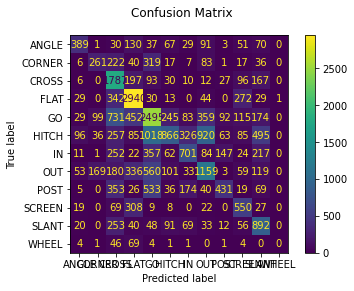

In [31]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle('Confusion Matrix')
print(f'Confusion Matrix:\n{disp.confusion_matrix}')
plt.show()

In [32]:
routes_df['route'].value_counts().sum()

65364

<BarContainer object of 12 artists>

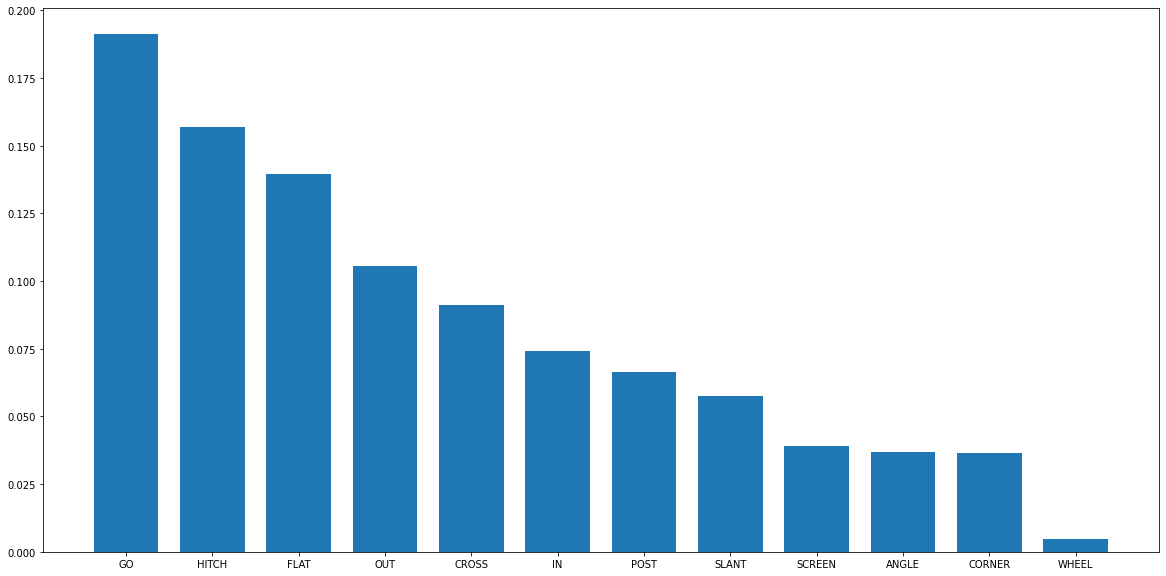

In [33]:
plt.figure(figsize=(20,10))
plt.bar(routes_df['route'].value_counts().index, routes_df['route'].value_counts().values / routes_df['route'].value_counts().sum(), width=0.75)

In [34]:
routes_df['route'].count()

65364

In [35]:
routes_df.loc[routes_df['route'] == 'WHEEL']['route'].count()

316

In [ ]:
7142/39645

## MLP Classifier

In [ ]:
clf2 = MLPClassifier(solver='lbfgs', random_state=1, max_iter=1000)
clf2.fit(x_train2, y_train)

In [ ]:
predicted2 = clf2.predict(x_test2)

In [ ]:
print(
    f'Classification report for classifier {clf2}:\n'
    f'{metrics.classification_report(y_test, predicted2)}\n'
)

In [ ]:
disp2 = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted2)
disp2.figure_.suptitle('Confusion Matrix')
print(f'Confusion Matrix:\n{disp2.confusion_matrix}')
plt.show()

## Random Forest

In [ ]:
model = RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_depth=10)

In [ ]:
model.fit(x_train2, y_train)

In [ ]:
y_pred = model.predict(x_test2)

In [ ]:
accuracy_score(y_pred, y_test)
print(classification_report(y_pred, y_test))

In [ ]:
confusion_matrix(y_pred, y_test)

## Pytorch

In [ ]:
classes = {}
index = 0
for route in routes_df['route'].unique().tolist():
    classes[index] = route
    index += 1
classes

In [ ]:
route_idx = {}
for idx, value in classes.items():
    route_idx[value] = idx
route_idx

In [ ]:
routes_df['route_int'] = routes_df['route'].apply(lambda x: route_idx[x])

In [ ]:
routes_df.loc[(routes_df['route_int'] == 12)]

In [ ]:
# Create device agnostic code
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device

In [ ]:
class MultiClassModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=0):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/ len(y_pred)) * 100
    return acc

In [ ]:
LEARNING_RATE = 0.5
EPOCHS = 2000
HIDDEN_UNITS = 256

In [ ]:
torch.manual_seed(42)
mc_model = MultiClassModel(input_features=x_dim*y_dim, output_features=len(classes), hidden_units=HIDDEN_UNITS).to(device)

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(mc_model.parameters(), lr=LEARNING_RATE)
epochs = EPOCHS

# Split data into 80% train and 20% test subsets
x_train, x_test, y_train, y_test = train_test_split(grids, routes_df['route_int'], test_size=0.2, shuffle=False, random_state=1)
x_train, y_train = torch.as_tensor(x_train).float().to(device), torch.as_tensor(y_train.to_numpy()).to(device)
x_test, y_test = torch.as_tensor(x_test).float().to(device), torch.as_tensor(y_test.to_numpy()).to(device)

for epoch in range(epochs):
    ### Training
    mc_model.train()

    # 1. Forward Pass
    y_logits = mc_model(x_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Calculate loss and energy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimiser zero grad (clear gradients)
    optimiser.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimiser step
    optimiser.step()

    ### Testing
    mc_model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = mc_model(x_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        pass
        #print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

In [ ]:
mc_model.eval()
with torch.inference_mode():
    y_logits = mc_model(x_test)

y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)

#print(f'Predictions: {y_preds}\nLabels: {y_test}')
print(f'Test accuracy: {accuracy_fn(y_true=y_test, y_pred=y_preds):.2f}%')

In [ ]:
len(routes_df)

In [ ]:
print(
    f'Classification report for classifier {mc_model}:\n'
    f'{metrics.classification_report(y_test.cpu(), y_preds.cpu())}\n'
)

In [ ]:
disp2 = metrics.ConfusionMatrixDisplay.from_predictions(y_test.cpu(), y_preds.cpu())
disp2.figure_.suptitle('Confusion Matrix')
print(f'Confusion Matrix:\n{disp2.confusion_matrix}')
plt.xlabel(classes)
plt.show()